In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os, json, requests
from dateutil import tz
from scipy.stats import gaussian_kde
from scipy.signal import correlate
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

In [2]:
def elevation_function(lat, long):
    elv_url = 'https://api.open-elevation.com/api/v1/lookup?locations={lat},{long}'
    elv_request_url = elv_url.format(long=long, lat=lat)
    elv_result = requests.get(url=elv_request_url, verify=True, timeout=3600.00)
    elv_content = json.loads(elv_result.content.decode('utf-8'))
    return(pd.DataFrame(elv_content['results'])['elevation'][0])

In [3]:
def get_nasa_weather(latitude, longitude, siteelv, start, end):
    #https://power.larc.nasa.gov/#resources for parameter codes, search in dropdown box
    #siteelv = elevation_function(latitude, longitude)
#    base_url = r"https://power.larc.nasa.gov//api/temporal/hourly/point?parameters=T2M,RH2M,PRECTOTCORR&time-standard=UTC&community=SB&longitude={longitude}&latitude={latitude}&site-elevation={siteelv}&start={start}&end={end}&format=JSON"
#    api_request_url = base_url.format(longitude=longitude, latitude=latitude, siteelv=siteelv, start=str(start), end=str(end))
    base_url = r"https://power.larc.nasa.gov//api/temporal/hourly/point?parameters=T2M,RH2M,PRECTOTCORR&time-standard=UTC&community=SB&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=JSON"
    api_request_url = base_url.format(longitude=longitude, latitude=latitude, start=str(start), end=str(end))
    
    response = requests.get(url=api_request_url, verify=True, timeout=3600.00)
    content = json.loads(response.content.decode('utf-8'))
    weather_df = pd.DataFrame(content['properties']['parameter'])
    weather_df['Date'] = pd.to_datetime(weather_df.index, format='%Y%m%d%H')
    weather_df = weather_df.reset_index(drop=True)
    
    # doing a pressure correction to the temprature based on the elevation
    #weather_df['T2M'] = (273+ weather_df['T2M'])*((weather_df['PSC']/100)**0.286) - 273
    weather_df.columns = (['Temp_nasa', 'RH_nasa', 'Rain_nasa','Pressure_nasa', 'Date'])
    weather_df[['Temp_nasa', 'RH_nasa', 'Rain_nasa']] = weather_df[['Temp_nasa', 'RH_nasa', 'Rain_nasa']].apply(pd.to_numeric, args=('coerce',))
    
    weather_df['Date'] = weather_df['Date'].dt.tz_localize('UTC').dt.tz_convert('Pacific/Auckland') # to be correct, should probably get the time zone from the gps coords
    weather_df = weather_df.replace(-999, np.nan)
    weather_df['Date'] = weather_df['Date'].apply(lambda x: x.replace(tzinfo=None))
    weather_df = weather_df.dropna()
    return(weather_df)

In [4]:
def get_niwa_data(location):
    gps = pd.read_csv('./data/'+location+'_rain_hourly.csv', nrows=2).loc[1][3:6]
    rain = pd.read_csv('./data/'+location+'_rain_hourly.csv', skiprows=8, skipfooter=8)[['Date(NZST)', 'Amount(mm)']]
    temps = pd.read_csv('./data/'+location+'_temps_hourly.csv', skiprows=8, skipfooter=8)[['Date(NZST)', 'Tmean(C)', 'RHmean(%)']]
    df = temps.merge(rain, on='Date(NZST)')
    df = df.rename(columns={"Date(NZST)": "Date", "Tmean(C)": "Temp_niwa", "RHmean(%)":"RH_niwa", "Amount(mm)":"Rain_niwa"})
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d:%H%M')
    df = df.replace('-', np.nan)
    df[['Temp_niwa', 'RH_niwa', 'Rain_niwa']] = df[['Temp_niwa', 'RH_niwa', 'Rain_niwa']].apply(pd.to_numeric, args=('coerce',))
    df = df.dropna()
    return(gps, df)


In [5]:
def create_combined_files(loc_list):
    for ll in loc_list:
        gps, df_niwa = get_niwa_data(ll)
        year_list = df_niwa['Date'].dt.year.unique()
        df_nasa = get_nasa_weather(gps[0], gps[1], gps[2], min(df_niwa[df_niwa['Date'].dt.year == year_list[0]]['Date']).strftime('%Y%m%d'), max(df_niwa[df_niwa['Date'].dt.year == year_list[0]]['Date']).strftime('%Y%m%d'))
        for yy in year_list[1:]:
            df_nasa = df_nasa.append(get_nasa_weather(gps[0], gps[1], gps[2], min(df_niwa[df_niwa['Date'].dt.year == yy]['Date']).strftime('%Y%m%d'), max(df_niwa[df_niwa['Date'].dt.year == yy]['Date']).strftime('%Y%m%d')))
        df = df_niwa.merge(df_nasa, on='Date')
        df.to_csv('./combined_files/elv_corrected_'+ll+'.csv', index=False)


In [6]:
loc_list = ['pukekohe','blenheim','motueka','wairoa','whakatu','methven','kaitaia', 'lincoln', 'winchmore'] 
#loc_list = ['pukekohe'] 


In [7]:
#create_combined_files(loc_list)

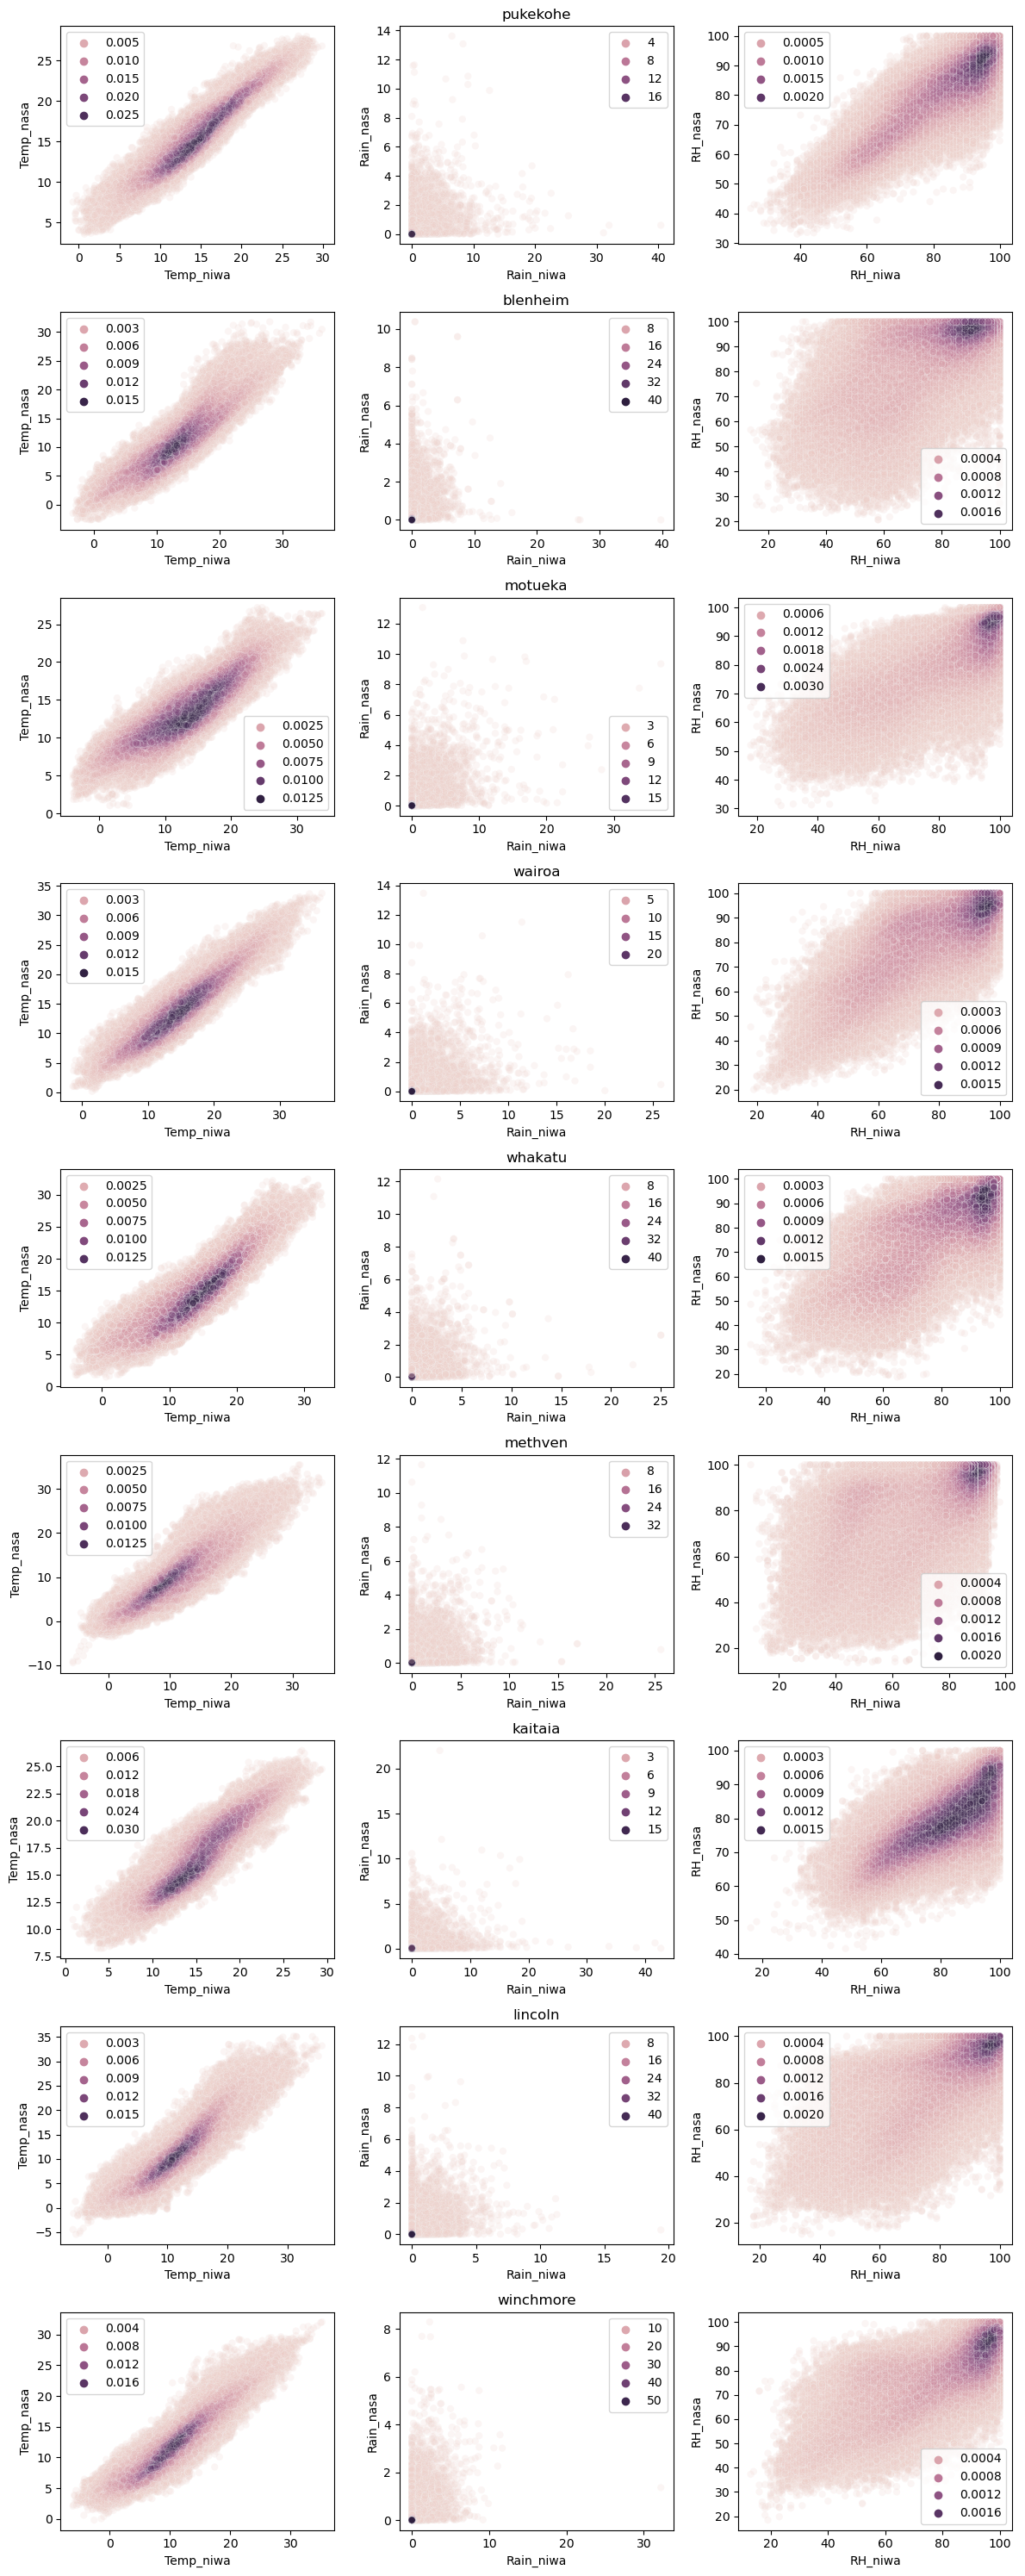

In [8]:
def make_subplots(loc_name, plot_row, fig_axes):
    df = pd.read_csv('./combined_files/'+loc_name+'.csv')
    #sb.kdeplot(x='Temp_niwa', y='Temp_nasa', data=df, fill=True, ax=fig_axes[plot_row, 0])
    xy_temp = np.vstack([df['Temp_niwa'], df['Temp_nasa']])
    z_temp = gaussian_kde(xy_temp)(xy_temp)
    sb.scatterplot(x='Temp_niwa', y='Temp_nasa', data=df, hue=z_temp, alpha=0.2, ax=fig_axes[plot_row, 0])
    xy_rain = np.vstack([df['Rain_niwa'], df['Rain_nasa']])
    z_rain = gaussian_kde(xy_rain)(xy_rain)
    sb.scatterplot(x='Rain_niwa', y='Rain_nasa', hue=z_rain, data=df, alpha=0.2, ax=fig_axes[plot_row, 1]).set(title=loc_name)
    xy_rh = np.vstack([df['RH_niwa'], df['RH_nasa']])
    z_rh = gaussian_kde(xy_rh)(xy_rh)
    sb.scatterplot(x='RH_niwa', y='RH_nasa', hue=z_rh, data=df, alpha=0.2, ax=fig_axes[plot_row, 2])
    #sb.kdeplot(x='RH_niwa', y='RH_nasa', data=df, fill=True, ax=fig_axes[plot_row, 2])
    #sb.violinplot((df['Temp_niwa']-df['Temp_nasa']), ax=fig_axes[plot_row, 2])



fig, fig_axes = plt.subplots(ncols=3, nrows=len(loc_list))
for ii, loc_name in enumerate(loc_list):
    make_subplots(loc_name, ii, fig_axes)
plt.tight_layout()
fig.savefig("kde_all_locations.png",facecolor='w') 

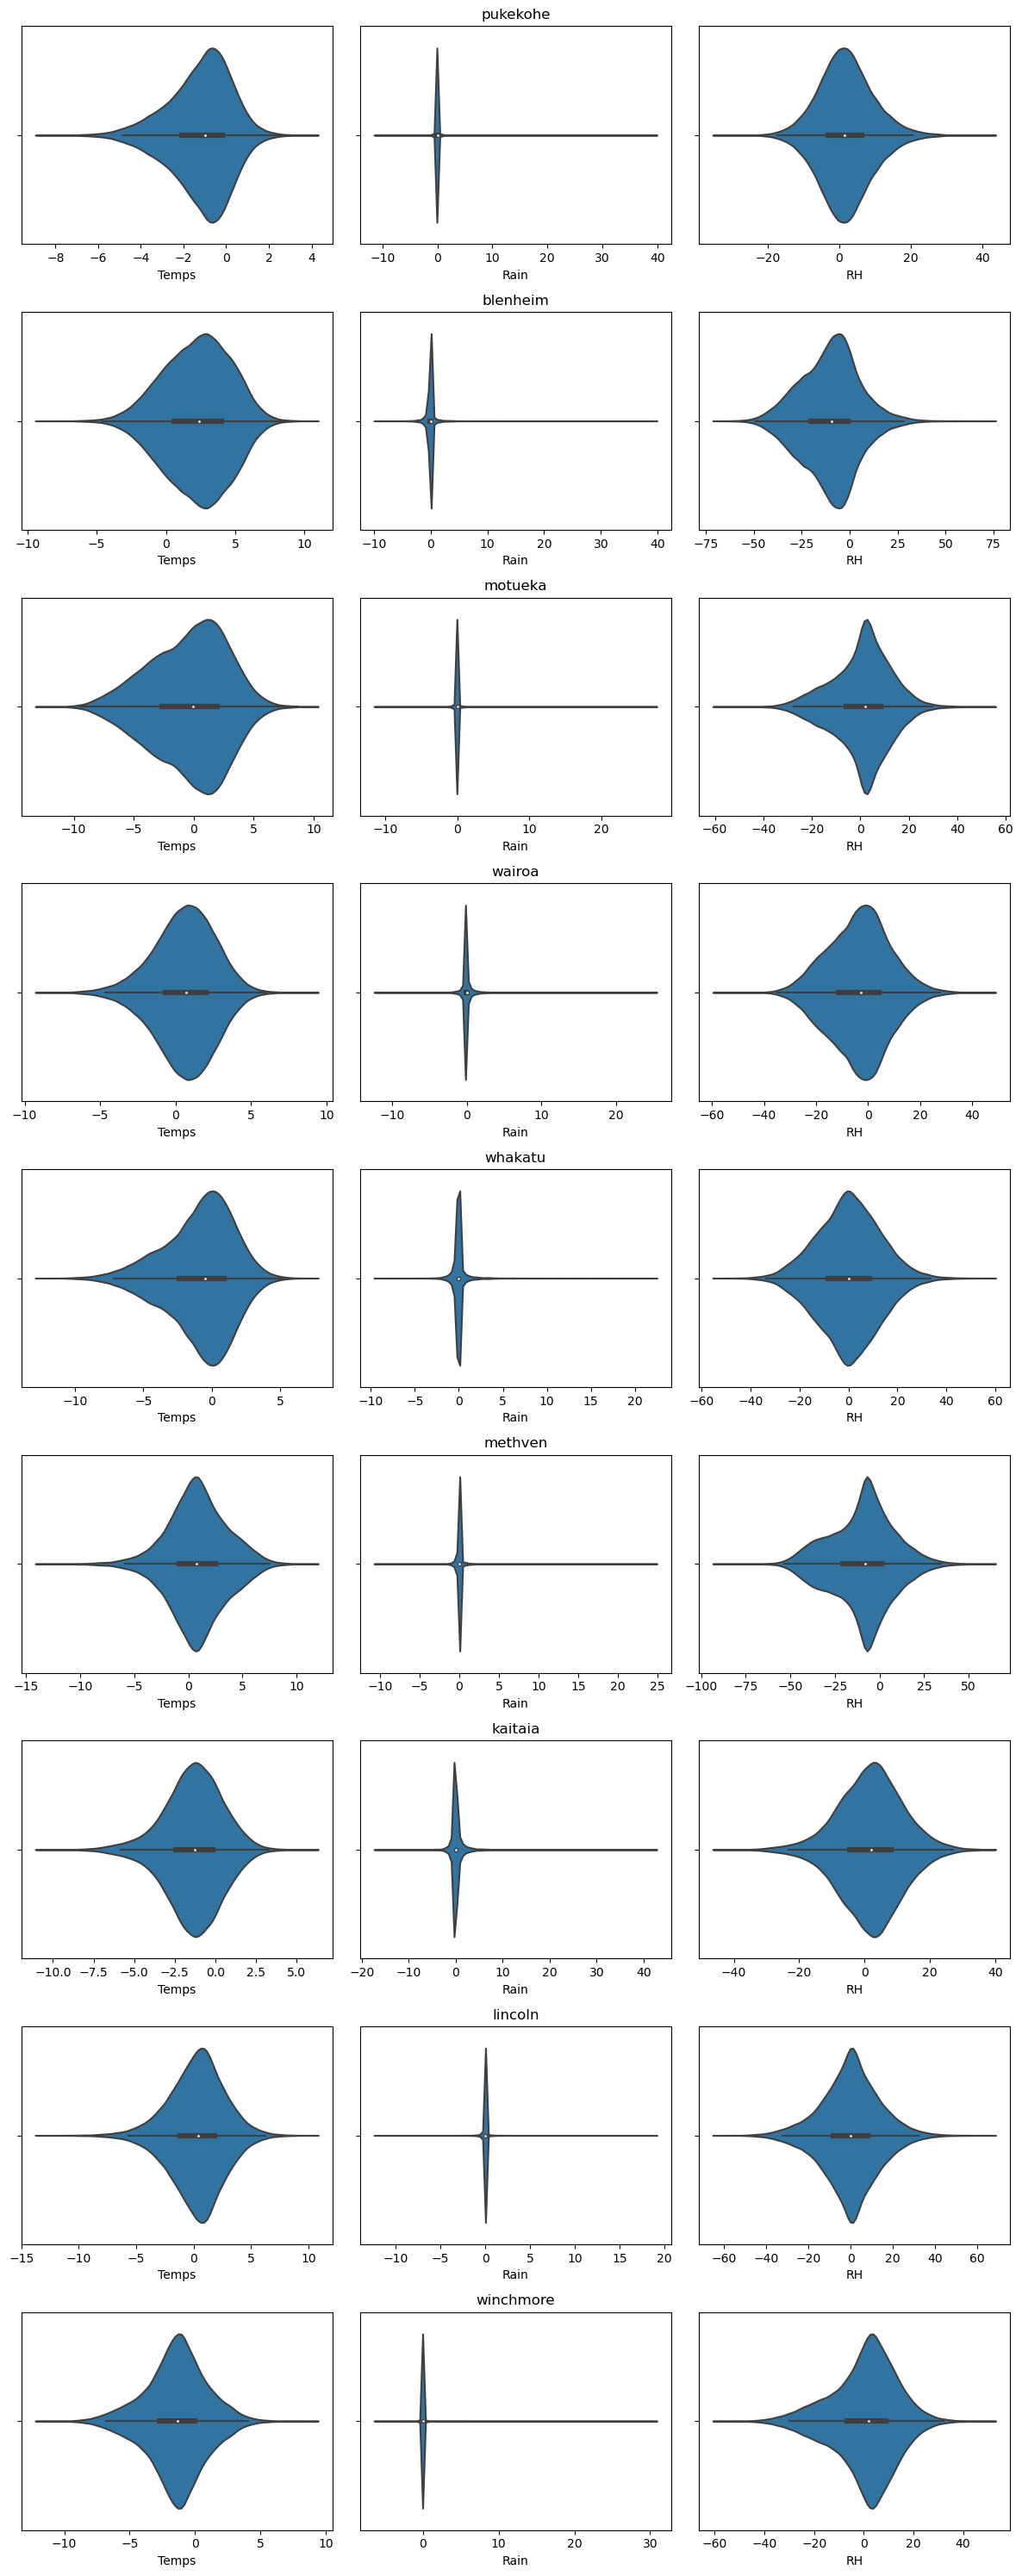

In [9]:
def make_difference_subplots(loc_name, plot_row, fig_axes):
    df = pd.read_csv('./combined_files/'+loc_name+'.csv')
    sb.violinplot(x=(df['Temp_niwa'] - df['Temp_nasa']), ax=fig_axes[plot_row, 0]).set(xlabel='Temps')
    sb.violinplot(x=(df['Rain_niwa'] - df['Rain_nasa']), ax=fig_axes[plot_row, 1]).set(title=loc_name, xlabel='Rain')
    sb.violinplot(x=(df['RH_niwa'] - df['RH_nasa']), ax=fig_axes[plot_row, 2]).set(xlabel='RH')



fig, fig_axes = plt.subplots(ncols=3, nrows=len(loc_list))
for ii, loc_name in enumerate(loc_list):
    make_difference_subplots(loc_name, ii, fig_axes)
plt.tight_layout()
fig.savefig("differences_all_locations.png",facecolor='w') 

In [10]:
Temp_acc_df = pd.DataFrame(columns=["Location", "Correlation", "MSE", "RMSE", "NRMSE", "MBE", "NMBE"])
for ii, loc_name in enumerate(loc_list):
    df = pd.read_csv('./combined_files/'+loc_name+'.csv')
    r2 = np.corrcoef(df['Temp_niwa'], df['Temp_nasa'])[0,1]
    mse = mean_squared_error(df['Temp_niwa'], df['Temp_nasa'])
    rmse = np.sqrt(mse)
    nrmse = rmse/np.mean(df['Temp_niwa'])
    mbe = np.mean(df['Temp_niwa'] - df['Temp_nasa'])
    nmbe = mbe/np.mean(df['Temp_niwa'])
    Temp_acc_df.loc[ii] = [loc_name, r2, mse, rmse, nrmse, mbe, nmbe]
Temp_acc_df

,Location,Correlation,MSE,RMSE,NRMSE,MBE,NMBE
0,pukekohe,0.948189,3.675852,1.917251,0.130593,-1.215441,-0.082789
1,blenheim,0.906107,10.777833,3.282961,0.248430,2.227651,0.168572
2,motueka,0.881713,10.430212,3.229584,0.248576,-0.421880,-0.032471
3,wairoa,0.932935,4.522743,2.126674,0.144476,0.585458,0.039773
4,whakatu,0.900359,7.172983,2.678242,0.198461,-0.894830,-0.066308
5,methven,0.896551,8.185278,2.860993,0.254046,0.787289,0.069909
6,kaitaia,0.908352,5.168231,2.273374,0.146969,-1.364080,-0.088185
7,lincoln,0.911226,6.019581,2.453484,0.204330,0.265467,0.022109
8,winchmore,0.925148,7.447978,2.729098,0.252397,-1.435899,-0.132797


In [11]:
Rain_acc_df = pd.DataFrame(columns=["Location", "Correlation", "MSE", "RMSE", "NRMSE", "MBE", "NMBE"])
for ii, loc_name in enumerate(loc_list):
    df = pd.read_csv('./combined_files/'+loc_name+'.csv')
    r2 = np.corrcoef(df['Rain_niwa'], df['Rain_nasa'])[0,1]
    mse = mean_squared_error(df['Rain_niwa'], df['Rain_nasa'])
    rmse = np.sqrt(mse)
    nrmse = rmse/np.mean(df['Rain_niwa'])
    mbe = np.mean(df['Rain_niwa'] - df['Rain_nasa'])
    nmbe = mbe/np.mean(df['Rain_niwa'])
    Rain_acc_df.loc[ii] = [loc_name, r2, mse, rmse, nrmse, mbe, nmbe]
Rain_acc_df

,Location,Correlation,MSE,RMSE,NRMSE,MBE,NMBE
0,pukekohe,0.406246,0.499669,0.706873,5.003466,0.019693,0.139390
1,blenheim,0.368212,0.198018,0.444992,7.233402,-0.045889,-0.745937
2,motueka,0.574764,0.462057,0.679747,4.642890,0.014394,0.098316
3,wairoa,0.469513,0.331474,0.575738,4.637521,0.015836,0.127560
4,whakatu,0.470616,0.173860,0.416965,5.815090,-0.021208,-0.295777
5,methven,0.437575,0.213545,0.462109,4.900724,-0.011269,-0.119505
6,kaitaia,0.343744,0.592540,0.769766,5.348736,0.025312,0.175878
7,lincoln,0.435023,0.156490,0.395588,6.017913,-0.041891,-0.637265
8,winchmore,0.513827,0.140123,0.374330,4.684891,0.001958,0.024505


In [12]:
RH_acc_df = pd.DataFrame(columns=["Location", "Correlation", "MSE", "RMSE", "NRMSE", "MBE", "NMBE"])
for ii, loc_name in enumerate(loc_list):
    df = pd.read_csv('./combined_files/'+loc_name+'.csv')
    r2 = np.corrcoef(df['RH_niwa'], df['RH_nasa'])[0,1]
    mse = mean_squared_error(df['RH_niwa'], df['RH_nasa'])
    rmse = np.sqrt(mse)
    nrmse = rmse/np.mean(df['RH_niwa'])
    mbe = np.mean(df['RH_niwa'] - df['RH_nasa'])
    nmbe = mbe/np.mean(df['RH_niwa'])
    RH_acc_df.loc[ii] = [loc_name, r2, mse, rmse, nrmse, mbe, nmbe]
RH_acc_df

,Location,Correlation,MSE,RMSE,NRMSE,MBE,NMBE
0,pukekohe,0.832998,61.323050,7.830904,0.097036,1.737457,0.021530
1,blenheim,0.588296,336.257772,18.337333,0.252663,-10.270556,-0.141514
2,motueka,0.744345,144.153923,12.006412,0.149447,0.779381,0.009701
3,wairoa,0.749253,151.116098,12.292929,0.163469,-3.492245,-0.046439
4,whakatu,0.690693,164.490263,12.825376,0.167617,0.021926,0.000287
5,methven,0.558144,405.211233,20.129859,0.296009,-9.608492,-0.141293
6,kaitaia,0.684478,101.753720,10.087305,0.125444,1.745921,0.021712
7,lincoln,0.676638,190.026970,13.785027,0.174637,-0.213083,-0.002699
8,winchmore,0.703548,170.583911,13.060778,0.169002,0.502434,0.006501
